##ASTAR

In [ ]:
from typing import Optional
import torch
import torch.nn as nn
import math
from dataclasses import dataclass
from typing import Optional, List
import torch.nn.functional as F



@dataclass
class AstarOutput:
    """
    Output structure of A* search planners
    """
    histories: torch.tensor
    paths: torch.tensor
    intermediate_results: Optional[List[dict]] = None


def get_heuristic(goal_maps: torch.tensor,
                  tb_factor: float = 0.001) -> torch.tensor:
    """
    Get heuristic function for A* search (chebyshev + small const * euclidean)

    Args:
        goal_maps (torch.tensor): one-hot matrices of goal locations
        tb_factor (float, optional): small constant weight for tie-breaking. Defaults to 0.001.

    Returns:
        torch.tensor: heuristic function matrices
    """

    # some preprocessings to deal with mini-batches
    num_samples, size = goal_maps.shape[0], goal_maps.shape[-1]
    grid = torch.meshgrid(torch.arange(0, size), torch.arange(0, size))
    loc = torch.stack(grid, dim=0).type_as(goal_maps)
    loc_expand = loc.reshape(2, -1).unsqueeze(0).expand(num_samples, 2, -1)
    goal_loc = torch.einsum("kij, bij -> bk", loc, goal_maps)
    goal_loc_expand = goal_loc.unsqueeze(-1).expand(num_samples, 2, -1)

    dxdy = torch.abs(loc_expand - goal_loc_expand)
    # chebyshev distance
    # h = dxdy.sum(dim=1) - dxdy.min(dim=1)[0]
    # euc = torch.sqrt(((loc_expand - goal_loc_expand)**2).sum(1))
    # h = (h + tb_factor * euc).reshape_as(goal_maps)

    # manhattan distance
    h = dxdy.sum(axis=1)
    h = (h).reshape_as(goal_maps)

    return h


def _st_softmax_noexp(val: torch.tensor) -> torch.tensor:
    """
    Softmax + discretized activation
    Used a detach() trick as done in straight-through softmax

    Args:
        val (torch.tensor): exponential of inputs.

    Returns:
        torch.tensor: one-hot matrices for input argmax.
    """

    val_ = val.reshape(val.shape[0], -1)
    y = val_ / (val_.sum(dim=-1, keepdim=True))
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y)
    y_hard[range(len(y_hard)), ind] = 1
    y_hard = y_hard.reshape_as(val)
    y = y.reshape_as(val)
    return (y_hard - y).detach() + y


def expand(x: torch.tensor, neighbor_filter: torch.tensor) -> torch.tensor:
    """
    Expand neighboring node 

    Args:
        x (torch.tensor): selected nodes
        neighbor_filter (torch.tensor): 3x3 filter to indicate 8 neighbors

    Returns:
        torch.tensor: neighboring nodes of x
    """

    x = x.unsqueeze(0)
    num_samples = x.shape[1]
    y = F.conv2d(x, neighbor_filter, padding=1, groups=num_samples).squeeze()
    y = y.squeeze(0)
    return y


def backtrack(start_maps: torch.tensor, goal_maps: torch.tensor,
              parents: torch.tensor, current_t: int) -> torch.tensor:
    """
    Backtrack the search results to obtain paths

    Args:
        start_maps (torch.tensor): one-hot matrices for start locations
        goal_maps (torch.tensor): one-hot matrices for goal locations
        parents (torch.tensor): parent nodes
        current_t (int): current time step

    Returns:
        torch.tensor: solution paths
    """

    num_samples = start_maps.shape[0]
    parents = parents.type(torch.long)
    goal_maps = goal_maps.type(torch.long)
    start_maps = start_maps.type(torch.long)
    path_maps = goal_maps.type(torch.long)
    num_samples = len(parents)
    loc = (parents * goal_maps.view(num_samples, -1)).sum(-1)
    for _ in range(current_t):
        path_maps.view(num_samples, -1)[range(num_samples), loc] = 1
        loc = parents[range(num_samples), loc]
    return path_maps


class DifferentiableAstar(nn.Module):
    def __init__(self, g_ratio: float = 0.5, Tmax: float = 0.25):
        """
        Differentiable A* module

        Args:
            g_ratio (float, optional): ratio between g(v) + h(v). Set 0 to perform as best-first search. Defaults to 0.5.
            Tmax (float, optional): how much of the map the planner explores during training. Defaults to 0.25.
        """

        super().__init__()

        neighbor_filter = torch.ones(1, 1, 3, 3)
        neighbor_filter[0, 0, 1, 1] = 0
        neighbor_filter[0, 0, 0, 0] = 0
        neighbor_filter[0, 0, 2, 2] = 0
        neighbor_filter[0, 0, 0, 2] = 0
        neighbor_filter[0, 0, 2, 0] = 0


        self.neighbor_filter = nn.Parameter(neighbor_filter,
                                            requires_grad=False)
        self.get_heuristic = get_heuristic

        self.g_ratio = g_ratio
        assert (Tmax > 0) & (Tmax <= 1), "Tmax must be within (0, 1]"
        self.Tmax = Tmax

    def forward(self,
                cost_maps: torch.tensor,
                start_maps: torch.tensor,
                goal_maps: torch.tensor,
                obstacles_maps: torch.tensor,
                store_intermediate_results: bool = False) -> AstarOutput:
        assert cost_maps.ndim == 4
        assert start_maps.ndim == 4
        assert goal_maps.ndim == 4
        assert obstacles_maps.ndim == 4

        cost_maps = cost_maps[:, 0]
        start_maps = start_maps[:, 0]
        goal_maps = goal_maps[:, 0]
        obstacles_maps = obstacles_maps[:, 0]

        num_samples = start_maps.shape[0]
        neighbor_filter = self.neighbor_filter
        neighbor_filter = torch.repeat_interleave(neighbor_filter, num_samples,
                                                  0)
        size = start_maps.shape[-1]

        open_maps = start_maps
        histories = torch.zeros_like(start_maps)
        intermediate_results = []

        h = self.get_heuristic(goal_maps)
        h = h + cost_maps
        g = torch.zeros_like(start_maps)

        parents = (
            torch.ones_like(start_maps).reshape(num_samples, -1) *
            goal_maps.reshape(num_samples, -1).max(-1, keepdim=True)[-1])

        size = cost_maps.shape[-1]
        Tmax = self.Tmax if self.training else 1.
        Tmax = int(Tmax * size * size)
        for t in range(Tmax):

            # select the node that minimizes cost
            f = self.g_ratio * g + (1 - self.g_ratio) * h
            f_exp = torch.exp(-1 * f / math.sqrt(cost_maps.shape[-1]))
            f_exp = f_exp * open_maps
            selected_node_maps = _st_softmax_noexp(f_exp)
            if store_intermediate_results:
                intermediate_results.append({
                    "histories":
                    histories.unsqueeze(1).detach(),
                    "paths":
                    selected_node_maps.unsqueeze(1).detach()
                })

            # break if arriving at the goal
            dist_to_goal = (selected_node_maps * goal_maps).sum((1, 2),
                                                                keepdim=True)
            is_unsolved = (dist_to_goal < 1e-8).float()

            histories = histories + selected_node_maps
            histories = torch.clamp(histories, 0, 1)
            open_maps = open_maps - is_unsolved * selected_node_maps
            open_maps = torch.clamp(open_maps, 0, 1)

            # open neighboring nodes, add them to the openlist if they satisfy certain requirements
            neighbor_nodes = expand(selected_node_maps, neighbor_filter)
            neighbor_nodes = neighbor_nodes * obstacles_maps

            # update g if one of the following conditions is met
            # 1) neighbor is not in the close list (1 - histories) nor in the open list (1 - open_maps)
            # 2) neighbor is in the open list but g < g2
            g2 = expand((g + cost_maps) * selected_node_maps, neighbor_filter)
            idx = (1 - open_maps) * (1 - histories) + open_maps * (g > g2)
            idx = idx * neighbor_nodes
            idx = idx.detach()
            g = g2 * idx + g * (1 - idx)
            g = g.detach()

            # update open maps
            open_maps = torch.clamp(open_maps + idx, 0, 1)
            open_maps = open_maps.detach()

            # for backtracking
            idx = idx.reshape(num_samples, -1)
            snm = selected_node_maps.reshape(num_samples, -1)
            new_parents = snm.max(-1, keepdim=True)[1]
            parents = new_parents * idx + parents * (1 - idx)

            if torch.all(is_unsolved.flatten() == 0):
                break

        # backtracking
        path_maps = backtrack(start_maps, goal_maps, parents, t)

        if store_intermediate_results:
            intermediate_results.append({
                "histories":
                histories.unsqueeze(1).detach(),
                "paths":
                path_maps.unsqueeze(1).detach()
            })

        return AstarOutput(histories.unsqueeze(1), path_maps.unsqueeze(1),
                           intermediate_results)


class VanillaAstar(nn.Module):
    def __init__(
        self,
        g_ratio: float = 0.5
    ):
        """
        Vanilla A* search

        Args:
            g_ratio (float, optional): ratio between g(v) + h(v). Set 0 to perform as best-first search. Defaults to 0.5.

        Examples:
            >>> planner = VanillaAstar()
            >>> outputs = planner(map_designs, start_maps, goal_maps)
            >>> histories = outputs.histories
            >>> paths = outputs.paths
        """

        super().__init__()
        self.astar = DifferentiableAstar(
            g_ratio=g_ratio,
            Tmax=1.0,
        )

    def forward(self,
                map_designs: torch.tensor,
                start_maps: torch.tensor,
                goal_maps: torch.tensor,
                cost_maps: torch.tensor = None,
                store_intermediate_results: bool = False) -> AstarOutput:
        obstacles_maps = map_designs

        astar_outputs = []
        if cost_maps != None:
          astar_outputs = self.astar(cost_maps, start_maps, goal_maps, obstacles_maps, store_intermediate_results)
        else:
          astar_outputs = self.astar(map_designs, start_maps, goal_maps, obstacles_maps, store_intermediate_results)

        return astar_outputs

In [ ]:
!nvidia-smi

Sat Jul 16 07:53:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##MAIN

In [ ]:
!git clone https://github.com/daniltirsk/neural-astar

Cloning into 'neural-astar'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 207 (delta 13), reused 40 (delta 10), pack-reused 160
Receiving objects: 100% (207/207), 80.61 MiB | 23.44 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [ ]:
%cd neural-astar
!pip install .

/content/neural-astar
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/neural-astar
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for neural-astar: filename=neural_astar-0.1.0-py3-none-any.whl size=11871 sha256=2c923d528ac8cbefafacd3186171b77680f3270d61424444bd8ae15f2d094734
  Stored in directory: /root/.cache/pip/wheels/e3/0e/7c/0f9c126ae8f463a446608b22e3e49c22d2c039444d6fa5f0e5
Successfully built neural-astar
  Attempting uninstall: neural-astar
    Found existing installation: neural-astar 0.1.0
    Uninstalling neural-astar-0.1.0:
      Successfully unin

In [ ]:
from neural_astar.utils.training import set_global_seeds, calc_metrics_from_multiple_results, visualize_results

In [ ]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
SHAPE = (64,64)
PATH = "/content/test_data_b"

In [ ]:
!unzip "/content/drive/MyDrive/tirskikh/test_dataset_4.zip"

Archive:  /content/drive/MyDrive/tirskikh/test_dataset_4.zip
  inflating: test_maps.npz           
  inflating: annotations.csv         
  inflating: heuristics_4.npz        


In [ ]:
annot = pd.read_csv("./annotations.csv")

In [ ]:
annot.head()

name  startx  starty  goalx  goaly
0     heatmap_0       1      33     35     41
1     heatmap_1      10      60     33      4
2    heatmap_10      50      39     30      7
3   heatmap_100      13       0     62     28
4  heatmap_1000      48      57     24     59

In [ ]:
heuristics = np.load("./heuristics_4.npz")

In [ ]:
maps = np.load("./test_maps.npz")

In [ ]:
TRAIN_SIZE = 10000
TEST_SIZE = 1000

In [ ]:
y_train = []
X_train = []

y_test = []
X_test = []

cnt = 0

for name in annot['name']:
    data = annot.loc[annot['name'] == name]
    map = np.unpackbits(maps[name], count=SHAPE[0]*SHAPE[1]).reshape(SHAPE).view(bool)
    start = np.zeros(SHAPE)
    start[data['starty'],data['startx']] = 1
    goal = np.zeros(SHAPE, dtype="uint8")
    goal[data['goaly'],data['goalx']] = 1

    heuristic = heuristics[name]
    if cnt < TRAIN_SIZE:
      new_x = np.stack([map,goal],axis=2)
      X_train.append(new_x)
      y_train.append(heuristic)
    else:
      new_x = np.stack([map,start,goal],axis=2)
      X_test.append(new_x)
      y_test.append(heuristic)

    cnt += 1
    if cnt%1000 == 0:
      print(cnt)

    if cnt == TRAIN_SIZE + TEST_SIZE:
      break

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [ ]:
len(X_test)

1000

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

In [ ]:
def normalize(image):
  image = tf.cast(image, tf.float32) / ((SHAPE[0]*SHAPE[1])/2 + SHAPE[0] - 1)
  return image

In [ ]:
def preprocess(map, heuristic):
  heuristic = normalize(heuristic)
  heuristic = tf.reshape(heuristic,[64,64,1])
  return map, heuristic

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
dataset_train = dataset_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset_test = dataset_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
batch = 64
buffer = 500
train_batches = dataset_train.cache().shuffle(buffer).batch(batch).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
test_batches = dataset_test.batch(batch)

In [ ]:
def display(items):
  plt.figure(figsize=(15,30))
  for i in range(len(items)):
    plt.subplot(1, len(items), i+1)
    plt.imshow(tf.keras.utils.array_to_img(items[i]))
    plt.axis('off')
  plt.show()

In [ ]:
def double_conv(x, n):
  x = layers.Conv2D(n, 3, padding='same', activation='relu')(x)
  x = layers.Conv2D(n, 3, padding='same', activation='relu')(x)
  return x

def downsample_k(x, n):
  dc = double_conv(x, n)
  p = layers.MaxPool2D(2)(dc)
  p = layers.Dropout(0.25)(p)
  return dc, p

def upsample_k(x, n, dc):
  x = layers.Conv2DTranspose(n, 3, 2, padding='same')(x)
  x = layers.concatenate([x, dc])
  x = layers.Dropout(0.25)(x)
  d = double_conv(x, n)
  return x

In [ ]:
def piecewise_mae(y_true,y_pred,a1=2,a2=2):
  
  # y_min = []
  # is_lower = tf.cast((sample_pred < y_min), tf.float32)

  is_greater =  tf.cast((y_pred > y_true), tf.float32)
  is_lower = tf.cast((y_pred < y_true), tf.float32)
  is_middle = tf.cast((y_pred == y_true), tf.float32)

  greater = tf.keras.metrics.mean_absolute_error(y_true * is_greater, y_pred * is_greater) * a2
  lower = tf.keras.metrics.mean_absolute_error(y_true * is_lower, y_pred * is_lower)


  return greater + lower

In [ ]:
#vanilla_astar(test_maps.to(device), test_starts.to(device), test_goals.to(device))

In [ ]:
loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")

device = "cuda" if torch.cuda.is_available() else "cpu"
vanilla_astar = VanillaAstar().to(device)

class CustomModel(keras.Model):
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions

        y_pred = self(tf.stack([x[:,:,:,0],x[:,:,:,2]],axis=3), training=False)
        
        loss = tf.keras.metrics.mean_absolute_error(y, y_pred)
        
        m = x[:,:,:,0].numpy()
        s = x[:,:,:,1].numpy()
        g = x[:,:,:,2].numpy()
        c = y_pred.numpy()


        maps = (np.abs(m-1)).reshape((-1,1,64,64)).astype(np.float32)
        goals = np.stack(g).reshape((-1,1,64,64)).astype(np.float32)
        starts = np.stack(s).reshape((-1,1,64,64)).astype(np.float32)
        costs = np.stack(c).reshape((-1,1,64,64)).astype(np.float32)

        maps = torch.Tensor(maps).to(device)
        goals = torch.Tensor(goals).to(device)
        starts = torch.Tensor(starts).to(device)
        costs = torch.Tensor(costs).to(device)

        search_cost_v = vanilla_astar(maps, starts, goals).histories
        search_cost_v = search_cost_v.sum(2).sum(2)

        search_cost_h = vanilla_astar(maps, starts, goals, cost_maps=costs.to(device)).histories
        search_cost_h = search_cost_h.sum(2).sum(2)

        search_cost = (search_cost_h/search_cost_v).mean().item()

        return {"loss": loss, "search_cost": search_cost}

In [ ]:
sample = next(iter(test_batches))
y = sample[1][45:50]
x = sample[0][45:50]

In [ ]:
m = x[:,:,:,0].numpy()
s = x[:,:,:,1].numpy()
g = x[:,:,:,2].numpy()
c = y[:,:,:,:].numpy()

In [ ]:
test_maps = (np.abs(m-1)).reshape((-1,1,64,64)).astype(np.float32)
test_goals = np.stack(g).reshape((-1,1,64,64)).astype(np.float32)
test_starts = np.stack(s).reshape((-1,1,64,64)).astype(np.float32)
test_costs = np.stack(c).reshape((-1,1,64,64)).astype(np.float32)

In [ ]:
test_maps = torch.Tensor(test_maps)
test_goals = torch.Tensor(test_goals)
test_starts = torch.Tensor(test_starts)
test_costs = torch.Tensor(test_costs)

In [ ]:
vanilla_astar = VanillaAstar().to(device)

In [ ]:
out = vanilla_astar(test_maps.to(device), test_starts.to(device), test_goals.to(device))

In [ ]:
model_k = tf.keras.models.load_model("/content/drive/MyDrive/tirskikh/a_star_heuristic_model_4_3")

In [ ]:
preds = model(tf.stack([x[:,:,:,0],x[0:5,:,:,2]],axis=3), training=False)

In [ ]:
c = preds

In [ ]:
costs = np.stack(c).reshape((-1,1,64,64)).astype(np.float32)
costs = torch.Tensor(costs).to(device)

In [ ]:
outh = vanilla_astar(test_maps.to(device), test_starts.to(device), test_goals.to(device), cost_maps = costs)

In [ ]:
outi = vanilla_astar(test_maps.to(device), test_starts.to(device), test_goals.to(device), cost_maps = test_costs.to(device))

(-0.5, 331.5, 67.5, -0.5)

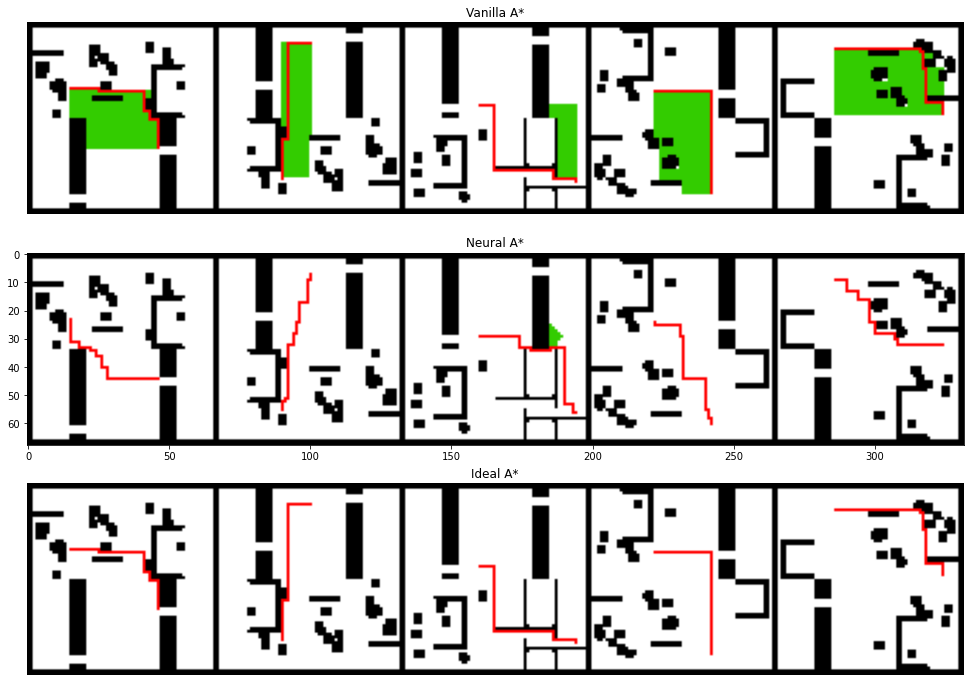

In [ ]:
plt.figure(figsize=[20, 12])
plt.subplot(3, 1, 1)
plt.imshow(visualize_results(test_maps, out))
plt.title("Vanilla A*")
plt.axis("off")
plt.subplot(3, 1, 2)
plt.imshow(visualize_results(test_maps, outh))
plt.title("Neural A*")
plt.subplot(3, 1, 3)
plt.imshow(visualize_results(test_maps, outi))
plt.title("Ideal A*")
plt.axis("off")

In [ ]:
# Create gif animation

import moviepy.editor as mpy
from PIL import Image

instance_id = 1

na_outputs = vanilla_astar(test_maps.to(device), test_starts.to(device), test_goals.to(device), cost_maps = costs.to(device), store_intermediate_results=True)
frames = [visualize_results(test_maps, intermediate_results) for intermediate_results in na_outputs.intermediate_results]
clip = mpy.ImageSequenceClip(frames + [frames[-1]] * 15, fps=30)
clip.write_gif("neural_astar.gif")

MoviePy - Building file neural_astar.gif with imageio.


In [ ]:
va_outputs = vanilla_astar(test_maps.to(device), test_starts.to(device), test_goals.to(device), store_intermediate_results=True)
frames = [visualize_results(test_maps, intermediate_results) for intermediate_results in va_outputs.intermediate_results]
clip = mpy.ImageSequenceClip(frames + [frames[-1]] * 15, fps=30)
clip.write_gif("astar.gif")

MoviePy - Building file astar.gif with imageio.


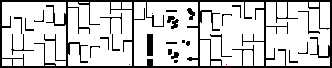

In [ ]:
from IPython.display import Image
Image(open("/content/neural-astar/astar.gif",'rb').read(),width=1000, height=200)

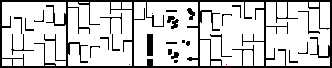

In [ ]:
from IPython.display import Image
Image(open("/content/neural-astar/neural_astar.gif",'rb').read(),width=1000, height=200)

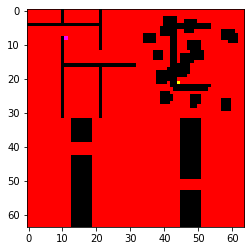

In [ ]:
plt.imshow(np.stack([test_maps[4],test_goals[4],test_starts[4]],axis=3).squeeze())

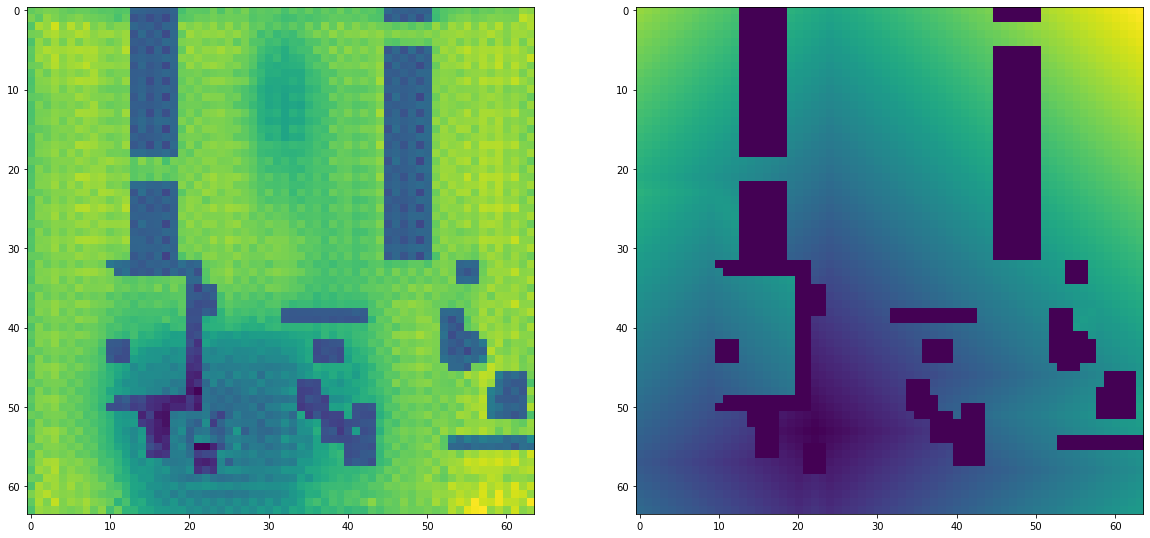

In [ ]:
plt.figure(figsize=[20, 12])
plt.subplot(1,2,1)
plt.imshow(costs[1].to('cpu').squeeze())
plt.subplot(1,2,2)
plt.imshow(test_costs[1].to('cpu').squeeze())
plt.show()

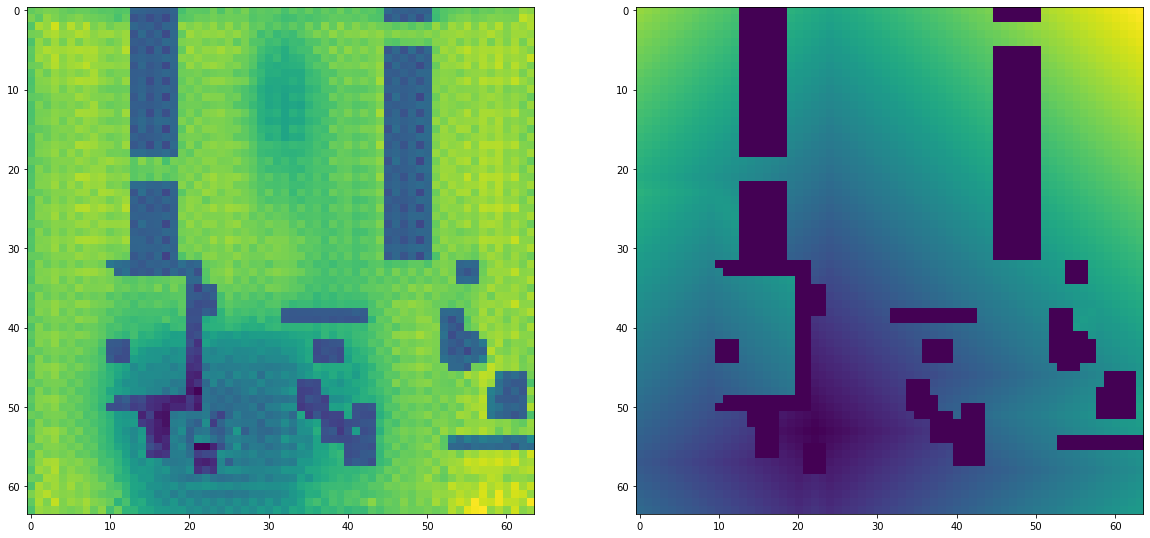

In [ ]:
plt.figure(figsize=[20, 12])
plt.subplot(1,2,1)
plt.imshow(costs[1].to('cpu').squeeze())
plt.subplot(1,2,2)
plt.imshow(test_costs[1].to('cpu').squeeze())
plt.show()

In [ ]:
h1 = out.histories.sum(2).sum(2)

tensor([[504.],
        [344.],
        [432.],
        [142.],
        [974.]], device='cuda:0')

In [ ]:
out = vanilla_astar(test_maps.to(device), test_starts.to(device), test_goals.to(device), cost_maps = test_costs.to(device))

In [ ]:
h2 = out.histories.sum(2).sum(2)

tensor([[ 85.],
        [ 68.],
        [ 86.],
        [ 99.],
        [ 69.],
        [289.],
        [ 50.],
        [ 73.],
        [ 96.],
        [ 73.],
        [ 70.],
        [ 54.],
        [ 50.],
        [ 62.],
        [169.],
        [321.],
        [ 67.],
        [ 71.],
        [ 66.],
        [ 66.],
        [ 64.],
        [149.],
        [121.],
        [ 75.],
        [ 78.],
        [ 69.],
        [257.],
        [170.],
        [331.],
        [ 91.],
        [ 68.],
        [ 56.],
        [ 58.],
        [ 82.],
        [104.],
        [ 55.],
        [ 48.],
        [ 68.],
        [ 57.],
        [ 85.],
        [116.],
        [ 81.],
        [ 61.],
        [117.],
        [ 74.],
        [101.],
        [156.],
        [ 65.],
        [ 65.],
        [ 62.],
        [ 62.],
        [306.],
        [ 75.],
        [ 58.],
        [115.],
        [256.],
        [130.],
        [ 46.],
        [ 63.],
        [ 61.],
        [ 60.],
        [ 64.],
        

In [ ]:
(h2/h1).mean().item()

0.3714621067047119

In [ ]:
def make_unet_k():
  input = layers.Input(shape=SHAPE + (2, ))
  dc1, p1 = downsample_k(input, 64)
  dc2, p2 = downsample_k(p1, 128)
  dc3, p3 = downsample_k(p2, 256)
  dc4, p4 = downsample_k(p3, 512)

  bottle = double_conv(p4, 1024)

  u6 = upsample_k(bottle, 512, dc4)
  u7 = upsample_k(u6, 256, dc3)
  u8 = upsample_k(u7, 128, dc2)
  out = upsample_k(u8, 64, dc1)

  output = layers.Conv2D(1, 1, padding="same", activation='relu')(out)
  
  model = CustomModel(input, output, name='UNet')

  return model

In [ ]:
model_k = make_unet_k()

In [ ]:
model_k.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_76 (Conv2D)             (None, 64, 64, 64)   1216        ['input_5[0][0]']                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 64, 64, 64)   36928       ['conv2d_76[0][0]']              
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 32, 32, 64)  0           ['conv2d_77[0][0]']              
 )                                                                                             

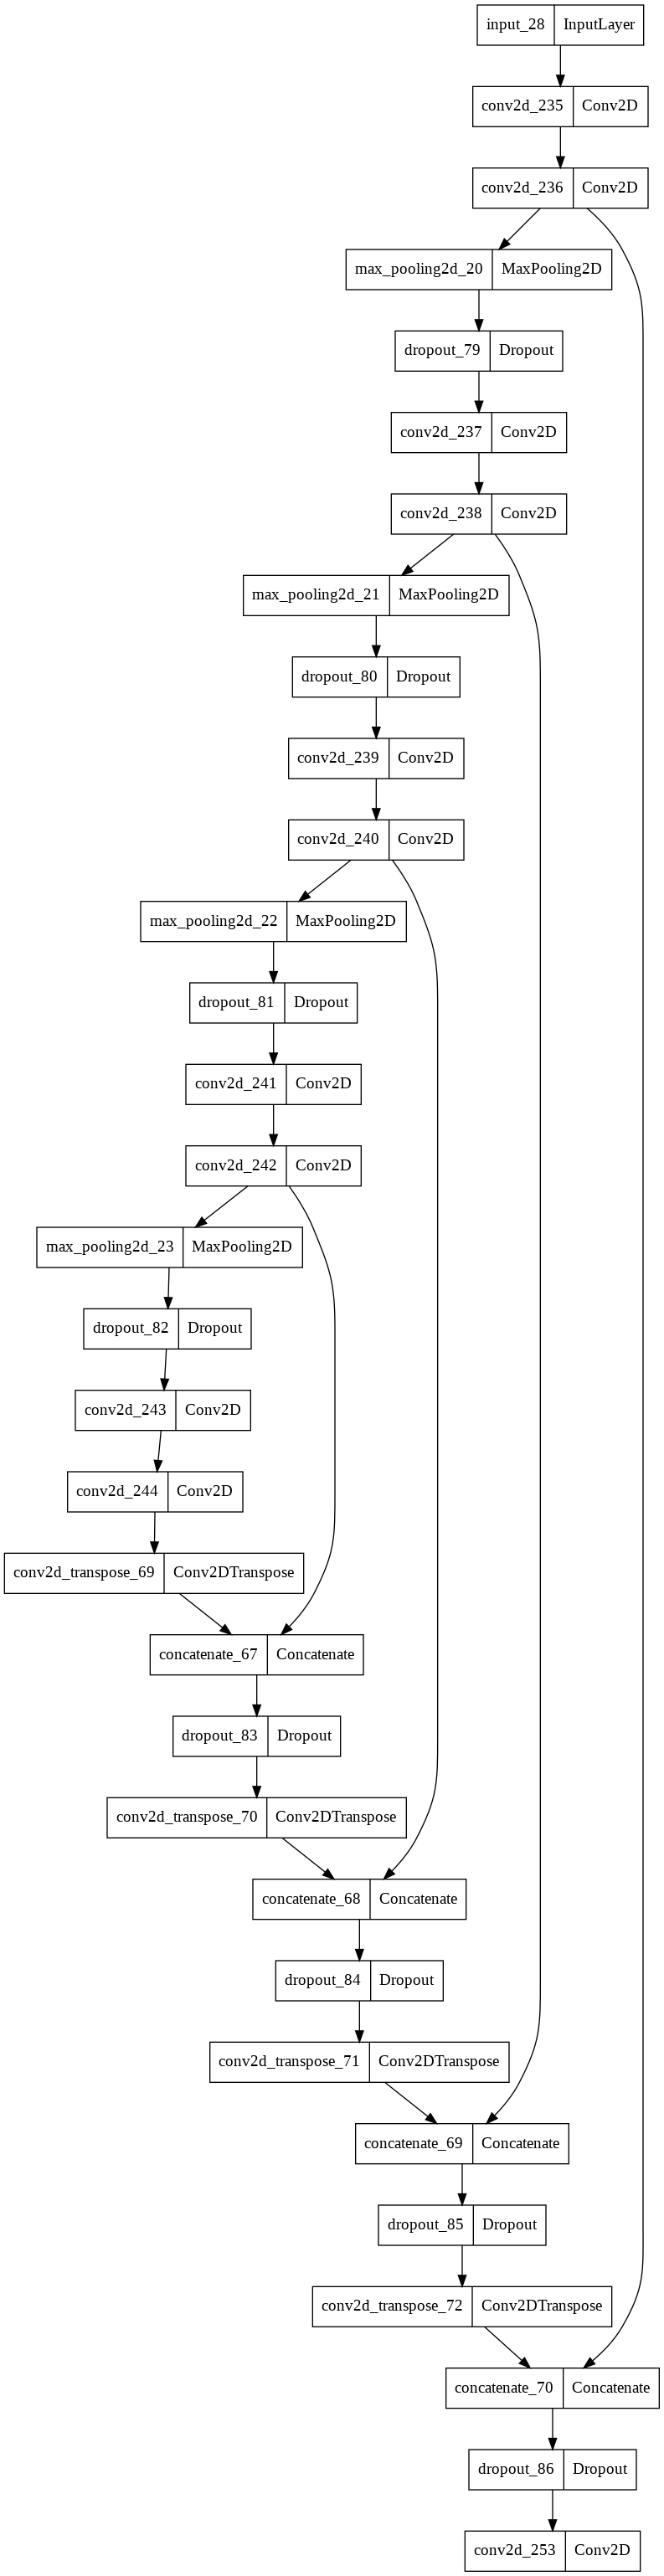

In [ ]:
plot_model(model_k)

In [ ]:
model_k.compile(optimizer='adam', loss="mae",run_eagerly=True)

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='val_search_cost',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

epoch = 100
ln = TRAIN_SIZE
steps = ln // batch
subsplits= 5
tln = TEST_SIZE
val_steps = tln // batch
history = model_k.fit(train_batches, epochs=epoch, validation_data=test_batches, steps_per_epoch=steps, validation_steps=val_steps, callbacks=[early_stopping_monitor])

Epoch 1/100
312/312 [==============================] - 77s 248ms/step - loss: 0.0059 - val_loss: 0.0048 - val_search_cost: 0.4760
Epoch 2/100
312/312 [==============================] - 67s 214ms/step - loss: 0.0029 - val_loss: 0.0041 - val_search_cost: 0.4311
Epoch 3/100
312/312 [==============================] - 67s 216ms/step - loss: 0.0024 - val_loss: 0.0034 - val_search_cost: 0.4432
Epoch 4/100
312/312 [==============================] - 77s 247ms/step - loss: 0.0021 - val_loss: 0.0037 - val_search_cost: 0.4298
Epoch 5/100
312/312 [==============================] - 77s 247ms/step - loss: 0.0019 - val_loss: 0.0033 - val_search_cost: 0.4408
Epoch 6/100
312/312 [==============================] - 67s 216ms/step - loss: 0.0017 - val_loss: 0.0030 - val_search_cost: 0.4387
Epoch 7/100
312/312 [==============================] - 67s 214ms/step - loss: 0.0016 - val_loss: 0.0029 - val_search_cost: 0.4289
Epoch 8/100
312/312 [==============================] - 77s 247ms/step - loss: 0.0015 - val

In [ ]:
0.4261

In [ ]:
model_k.compile(optimizer='adam', loss=piecewise_mae, metrics='accuracy',run_eagerly=True)

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='val_search_cost',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

epoch = 100
ln = TRAIN_SIZE
steps = ln // batch
subsplits= 5
tln = TEST_SIZE
val_steps = tln // batch
history = model_k.fit(train_batches, epochs=epoch, validation_data=test_batches, steps_per_epoch=steps, validation_steps=val_steps, callbacks=[early_stopping_monitor])

Epoch 1/100
312/312 [==============================] - 78s 251ms/step - loss: 0.0061 - accuracy: 0.1832 - val_loss: 0.0053 - val_search_cost: 0.4466
Epoch 2/100
312/312 [==============================] - 68s 218ms/step - loss: 0.0030 - accuracy: 0.1832 - val_loss: 0.0049 - val_search_cost: 0.4431
Epoch 3/100
312/312 [==============================] - 68s 220ms/step - loss: 0.0028 - accuracy: 0.1831 - val_loss: 0.0043 - val_search_cost: 0.4390
Epoch 4/100
312/312 [==============================] - 77s 248ms/step - loss: 0.0025 - accuracy: 0.1832 - val_loss: 0.0046 - val_search_cost: 0.4349
Epoch 5/100
312/312 [==============================] - 77s 248ms/step - loss: 0.0023 - accuracy: 0.1831 - val_loss: 0.0035 - val_search_cost: 0.4290
Epoch 6/100
312/312 [==============================] - 77s 248ms/step - loss: 0.0021 - accuracy: 0.1831 - val_loss: 0.0034 - val_search_cost: 0.4305
Epoch 7/100
312/312 [==============================] - 67s 216ms/step - loss: 0.0020 - accuracy: 0.1833 - 

In [ ]:
map, heuristic = list(dataset_test.take(100))[42]

In [ ]:
prediction = model_k.predict(map[tf.newaxis, ...]).reshape(*SHAPE,1)

ValueError: ignored

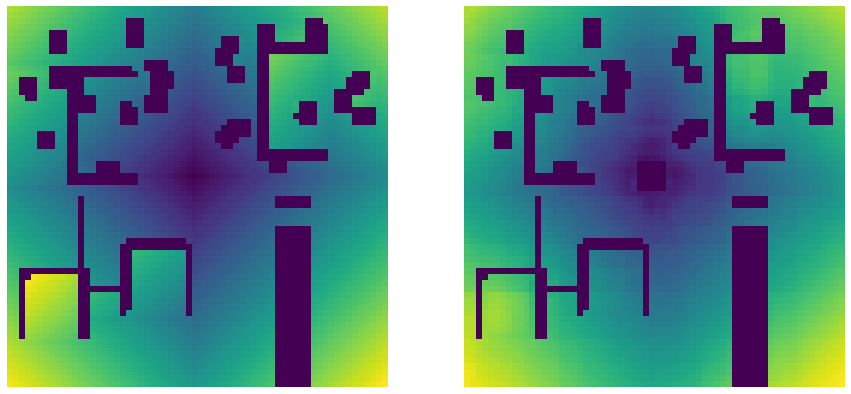

In [ ]:
display([heuristic, prediction])

In [ ]:
np.min(heuristic)

0.0

In [ ]:
np.max(prediction)

0.02845206

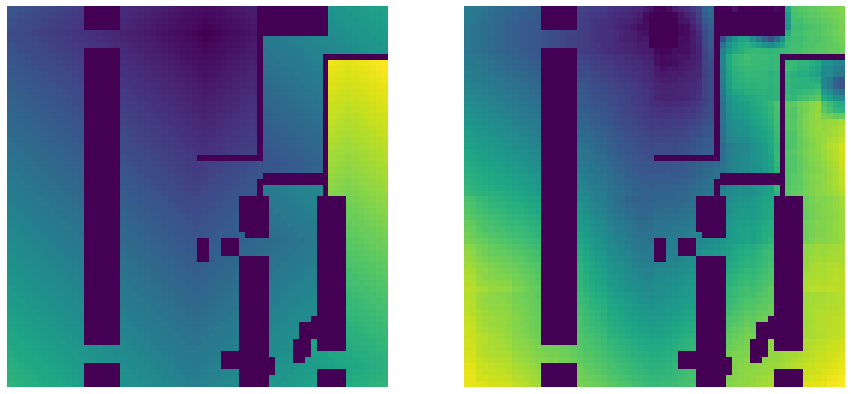

In [ ]:
display([heuristic, prediction])

In [ ]:
def downsample(x, n):
  dc = layers.Conv2D(n, 3, padding='same', activation=layers.LeakyReLU())(x)
  p = layers.Dropout(0.25)(dc)
  p = layers.BatchNormalization()(p)
  p = layers.AvgPool2D(2)(p)
  return dc, p

def upsample(x, n, dc):
  x = layers.concatenate([x, dc])
  x = layers.Conv2D(n, 3, padding='same', activation=layers.LeakyReLU())(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2DTranspose(n, 3, 2, padding='same')(x)
  return x

def make_unet():
  input = layers.Input(shape=SHAPE + (2, ))

  dc1 = layers.Conv2D(128, 3, padding='same', activation=layers.LeakyReLU())(input)
  p1 = layers.BatchNormalization()(dc1)
  p1 = layers.AvgPool2D(2)(p1)
  
  dc2, p2 = downsample(p1, 256)
  dc3, p3 = downsample(p2, 1024)

  p4 = layers.Conv2D(1024, 3, padding='same', activation=layers.LeakyReLU())(p3)
  p4 = layers.BatchNormalization()(p4)
  p4 = layers.Conv2DTranspose(512, 3, 2, padding='same')(p4)

  u6 = upsample(p4, 256, dc3)
  u7 = upsample(u6, 128, dc2)
  
  out = layers.concatenate([u7, dc1])
  out = layers.Conv2D(128, 3, padding='same', activation=layers.LeakyReLU())(out)
  out = layers.BatchNormalization()(out)


  output = layers.Conv2D(1, 1, padding="same", activation='tanh')(out)
  
  model = CustomModel(input, output, name='UNet')

  return model

In [ ]:
model = make_unet()

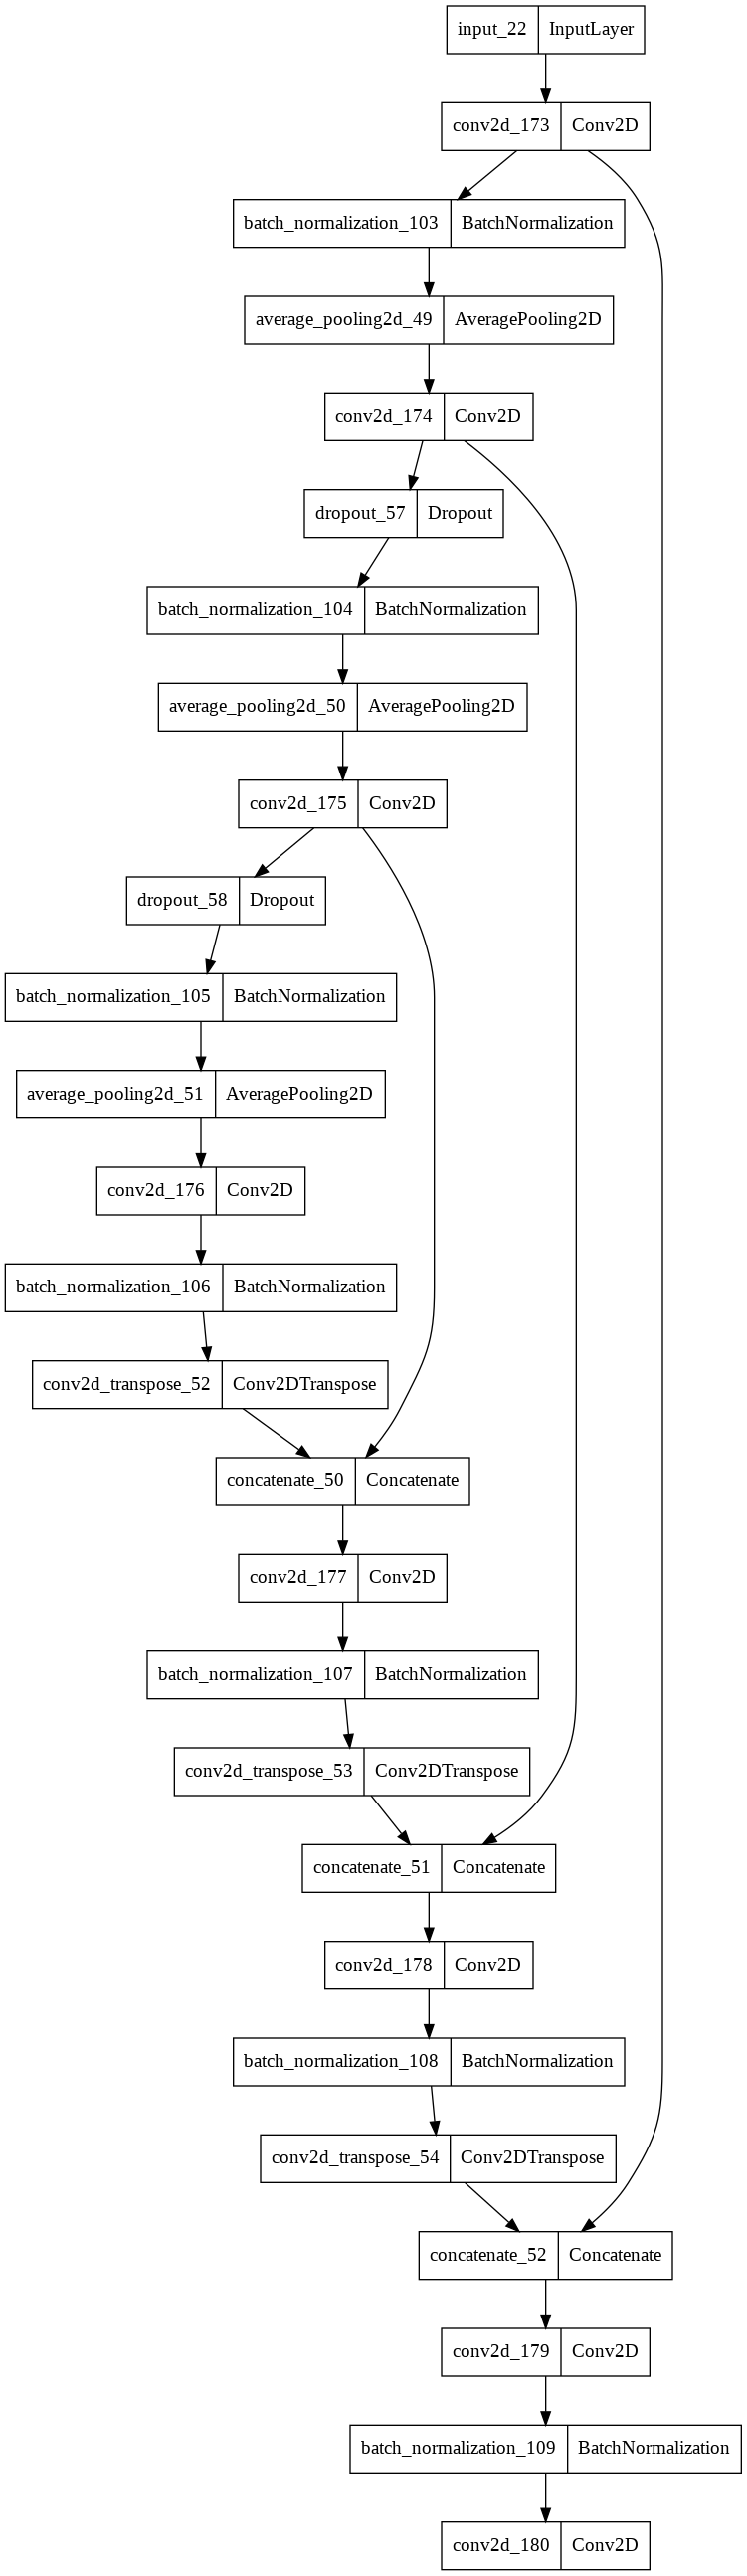

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 128)  2432        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64, 64, 128)  512        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 32, 32, 128)  0          ['batch_normalization_7[0][0]'

In [ ]:
model.compile(optimizer='adam', loss='mae', metrics='accuracy',run_eagerly=True)

In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='val_search_cost',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

epoch = 50
ln = TRAIN_SIZE
steps = ln // batch
subsplits= 5
tln = TEST_SIZE
val_steps = tln // batch
history = model.fit(train_batches, epochs=epoch, validation_data=test_batches, steps_per_epoch=steps, validation_steps=val_steps, callbacks=[early_stopping_monitor])

Epoch 1/50
156/156 [==============================] - 76s 470ms/step - loss: 0.0716 - accuracy: 0.1769 - val_loss: 0.0111 - val_search_cost: 0.4472
Epoch 2/50
156/156 [==============================] - 62s 398ms/step - loss: 0.0127 - accuracy: 0.1849 - val_loss: 0.0083 - val_search_cost: 0.4440
Epoch 3/50
156/156 [==============================] - 72s 465ms/step - loss: 0.0113 - accuracy: 0.1848 - val_loss: 0.0075 - val_search_cost: 0.4551
Epoch 4/50
156/156 [==============================] - 72s 466ms/step - loss: 0.0139 - accuracy: 0.1849 - val_loss: 0.0080 - val_search_cost: 0.4644
Epoch 5/50
156/156 [==============================] - 72s 466ms/step - loss: 0.0093 - accuracy: 0.1849 - val_loss: 0.0075 - val_search_cost: 0.4075
Epoch 6/50
156/156 [==============================] - 61s 392ms/step - loss: 0.0093 - accuracy: 0.1848 - val_loss: 0.0097 - val_search_cost: 0.4540
Epoch 7/50
156/156 [==============================] - 61s 394ms/step - loss: 0.0064 - accuracy: 0.1848 - val_los

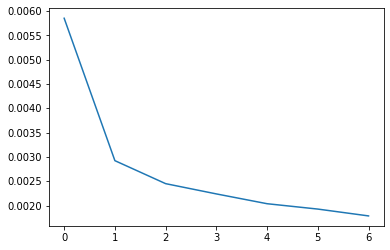

In [ ]:
plt.plot(history.epoch, history.history['loss'])

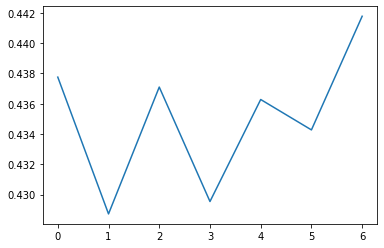

In [ ]:
plt.plot(history.epoch, history.history['val_search_cost'])

In [ ]:
map, heuristic = list(dataset.skip(10000).take(100))[4]

In [ ]:
prediction = model.predict(map[tf.newaxis, ...]).reshape(*SHAPE,1)

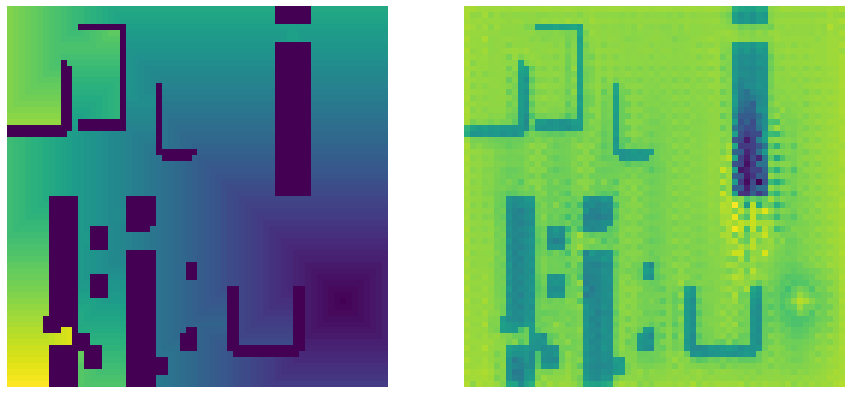

In [ ]:
display([heuristic, prediction])

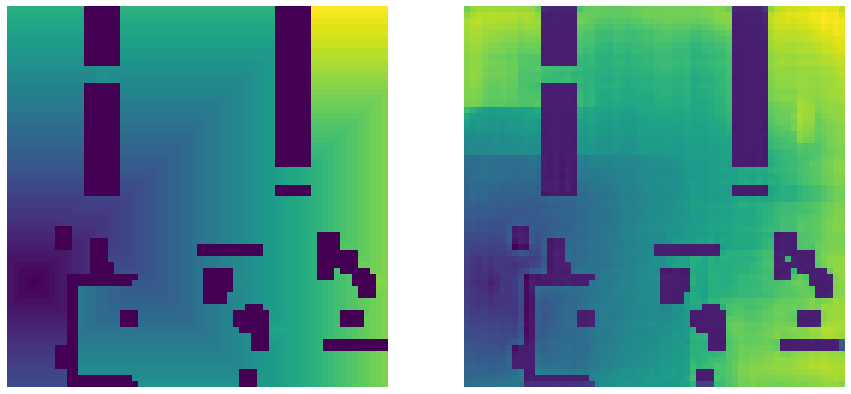

In [ ]:
display([heuristic, prediction])

In [ ]:
model.save("/content/drive/MyDrive/tirskikh/a_star_heuristic_model_4_their")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tirskikh/a_star_heuristic_model_4_their/assets
